In [1]:
import numpy as np
import tensorflow as tf
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from scipy import stats
import joblib

#working directory (needed for saving models)
filepath_wd = ".../Resultate_final/working_directory/"
#directory for results
filepath = ".../Resultate_final/VarAnn/saved_single_run/"

In [2]:
#parameters as in section 4.3 of 'Assessing Asset-Liability risk with Neural Networks' (Cheridito, Ery, Wüthrich 2020)
#and section 5.1 of 'A Least-Squares Monte Carlo Approach to the Estimation of Enterprise Risk' (Ha, Bauer 2019)
#parameters for q
q_0 = 4.605
m = 0.05
sigma_S = 0.18
#parameters for r
r_0 = 0.025
zeta = 0.25
gamma = 0.02
sigma_r = 0.01
lambd = 0.02
gamma_bar = gamma - (lambd*sigma_r)/zeta
#parameters for mu_(55+t)
mu_55 = 0.01
kappa = 0.07
sigma_mu = 0.0012
#parameters for brownian motion
rho_12 = -0.3
rho_13 = 0.06
rho_23 = -0.04
cov_mat = np.array([[1,rho_12,rho_13],[rho_12,1,rho_23],[rho_13,rho_23,1]])
#horizon parameters
tau = 1
T = 15
b = 10.792
#risk measure parameters
alpha_VaR = 0.995
alpha_ES = 0.99
alpha_Glue = 0.95
beta_Glue = 0.995
omega_Glue = np.array([1/3,1/3])
#Sizes for training, validation, test, and set size for Monte Carlo estimation of the risk measures
M_1 = 1500000
M_2 = 500000
M_3 = 500000
#ignore N or N_2 in the following. Was kept just in case, but not used.
N_2 = 1
M_MC = 500000

In [4]:
#Definition of these functions analogously to the appendix of 'A Least-Squares Monte Carlo Approach to the Estimation of Enterprise Risk' (Ha, Bauer 2019)
def B_r(t,T):
    return ((1-np.exp(-zeta*(T-t)))/zeta)
def B_mu(t,T):
    return ((np.exp(kappa*(T-t))-1)/kappa)
def A(t,T):
    tmp1 = gamma_bar*(B_r(t,T)-(T-t))
    tmp2 = (sigma_r/zeta)**2 * ((T-t) - 2*B_r(t,T) + (1-np.exp(-2*zeta*(T-t)))/(2*zeta))
    tmp3 = (sigma_mu/kappa)**2 * ((T-t) - 2*B_mu(t,T) + (np.exp(2*kappa*(T-t))-1)/(2*kappa))
    tmp4 =  2*rho_23*sigma_r*sigma_mu/(zeta*kappa) * (B_mu(t,T) - (T-t) + B_r(t,T) - (1-np.exp(-(zeta-kappa)*(T-t)))/(zeta-kappa))
    return np.exp(tmp1+0.5*(tmp2+tmp3+tmp4))
#Definition of this function analogously to section 4.3 of 'Assessing Asset-Liability risk with Neural Networks' (Cheridito, Ery, Wüthrich 2020)
def F(t,k,r_t,mu_xt):
    return (A(t,t+k)*np.exp(-B_r(t,t+k)*r_t - B_mu(t,t+k)*mu_xt))

#parameters of the normal distribution of X_tau according to the appendix of 'A Least-Squares Monte Carlo Approach to the Estimation of Enterprise Risk' (Ha, Bauer 2019)
mu_q_tau = q_0 + (m-0.5*(sigma_S**2))*tau
mu_r_tau = r_0*np.exp(-zeta*tau) + gamma*(1-np.exp(-zeta*tau))
mu_mu_55_tau = mu_55*np.exp(kappa*tau)
mean_tau = np.array([mu_q_tau, mu_r_tau, mu_mu_55_tau])

cov_q_r_tau = rho_12*sigma_S*sigma_r*B_r(0,tau)
cov_q_mu_tau = rho_13*sigma_S*sigma_mu*B_mu(0,tau)
cov_r_mu_tau = rho_23*sigma_r*sigma_mu* ((1-np.exp(-(zeta-kappa)*tau))/(zeta-kappa))
var_q_tau = (sigma_S**2) * tau
var_r_tau = (sigma_r**2) * ((1-np.exp(-2*zeta*tau))/(2*zeta))
var_mu_tau = (sigma_mu**2) * ((np.exp(2*kappa*tau)-1)/(2*kappa))
cov_mat_tau = np.array([[var_q_tau, cov_q_r_tau, cov_q_mu_tau], [cov_q_r_tau, var_r_tau, cov_r_mu_tau], [cov_q_mu_tau, cov_r_mu_tau, var_mu_tau]])
C_tau = np.linalg.cholesky(cov_mat_tau)

#variance/covariance parameters of the conditional normal distribution of X_T according to the appendix of 'A Least-Squares Monte Carlo Approach to the Estimation of Enterprise Risk' (Ha, Bauer 2019)
var_q_T_cond = (sigma_S**2) *(T-tau) + ((sigma_r/zeta)**2) * (T-tau - 2*(1-np.exp(-zeta*(T-tau)))/zeta + (1-np.exp(-2*zeta*(T-tau)))/(2*zeta)) + (2*rho_12*sigma_S*sigma_r/zeta) * (T-tau- (1-np.exp(-zeta*(T-tau)))/zeta)
cov_q_r_T_cond = rho_12*sigma_S*sigma_r*((1-np.exp(-zeta*(T-tau)))/zeta) + ((sigma_r**2)/zeta) * ((1-2*np.exp(-zeta*(T-tau))+np.exp(-2*zeta*(T-tau)))/(2*zeta))
cov_q_mu_T_cond = rho_13*sigma_S*sigma_mu *((np.exp(kappa*(T-tau))-1)/kappa) + (rho_23*sigma_r*sigma_mu/zeta) * ((np.exp(kappa*(T-tau))-1)/kappa - (1-np.exp(-(zeta-kappa)*(T-tau)))/(zeta-kappa))
var_r_T_cond = (sigma_r**2) * ((1-np.exp(-2*zeta*(T-tau)))/(2*zeta))
cov_r_mu_T_cond = rho_23*sigma_r*sigma_mu*((1-np.exp(-(zeta-kappa)*(T-tau)))/(zeta-kappa))
var_mu_T_cond = (sigma_mu**2) * ((np.exp(2*kappa*(T-tau))-1)/(2*kappa))
cov_mat_T_cond = np.array([[var_q_T_cond, cov_q_r_T_cond, cov_q_mu_T_cond], [cov_q_r_T_cond, var_r_T_cond, cov_r_mu_T_cond], [cov_q_mu_T_cond, cov_r_mu_T_cond, var_mu_T_cond]])

#function for generating simulated risk factors X_tau and corresponding payments Y
def data_gen(M,N):
    #simulation of X_tau
    Z = np.random.multivariate_normal(mean=np.full(3,0),cov=np.identity(3),size=int(M/N))
    Z_T = np.random.multivariate_normal(mean=np.full(3,0),cov=cov_mat_T_cond,size=M)
    X_pre = np.transpose(np.matmul(C_tau,np.transpose(Z))) + np.tile(mean_tau, (M,1))
    X_tau = np.tile(X_pre, (N,1))
    np.random.shuffle(X_tau)

    #simulation of X_T given X_tau
    mu_q_T_cond = X_tau[:,0] + B_r(tau,T)*X_tau[:,1] + (gamma_bar - (sigma_r/zeta)**2)*(T-tau - (1-np.exp(-zeta*(T-tau)))/zeta) + 0.5*((sigma_r/zeta)**2) * ((1-np.exp(-zeta*(T-tau)))/zeta - (np.exp(-zeta*(T-tau))-np.exp(-2*zeta*(T-tau)))/zeta) - ((rho_23*sigma_r*sigma_mu)/kappa) * ( (np.exp(kappa*(T-tau))-1)/(kappa*(zeta-kappa)) - (np.exp(kappa*(T-tau))-np.exp(-(zeta-kappa)*(T-tau)))/(zeta*(zeta-kappa)) - (1/zeta) * (T-tau - (1-np.exp(-zeta*(T-tau)))/zeta)) -0.5*(sigma_S**2) * (T-tau) - (rho_12*sigma_S*sigma_r/zeta) * (T-tau - (1-np.exp(-zeta*(T-tau)))/zeta) - (rho_13*sigma_S*sigma_mu/kappa) * ((np.exp(kappa*(T-tau))-1)/kappa -T+tau)
    mu_r_T_cond = np.exp(-zeta*(T-tau))*X_tau[:,1] + (gamma_bar-(sigma_r/zeta)**2)*(1-np.exp(-zeta*(T-tau))) + 0.5*((sigma_r/zeta)**2) *(1-np.exp(-2*zeta*(T-tau))) - (rho_23*sigma_r*sigma_mu/kappa) * ((1-np.exp(-(zeta-kappa)*(T-tau)))/(zeta-kappa) - (1-np.exp(-zeta*(T-tau)))/zeta)
    mu_mu_T_cond = np.exp(kappa*(T-tau))*X_tau[:,2] - (rho_23*sigma_r*sigma_mu/zeta) * ((np.exp(kappa*(T-tau))-1)/kappa - (1-np.exp(-(zeta-kappa)*(T-tau)))/(zeta-kappa)) - ((sigma_mu**2)/kappa) * ((np.exp(2*kappa*(T-tau))-1)/(2*kappa) - (np.exp(kappa*(T-tau))-1)/kappa)
    mean_T_cond = np.array([mu_q_T_cond, mu_r_T_cond, mu_mu_T_cond])

    X_T = np.empty((M*N,3))
    X_T = Z_T + np.transpose(mean_T_cond)

    #calculation of Y from X_T and X_tau
    Y = F(t=tau, k=T-tau, r_t=X_tau[:,1], mu_xt=X_tau[:,2]) * np.maximum(np.exp(X_T[:,0]), b*np.sum([F(t=T, k=i, r_t=X_T[:,1], mu_xt=X_T[:,2]) for i in range(1,51)], axis=0))
    return X_tau, Y

#function for estimation of GlueVaR
def GlueVaR(omega, L, alpha, beta):
    j_beta = int(len(L)*(1-beta))-1
    j_alpha = int(len(L)*(1-alpha))-1

    ES_beta = 1/(1-beta) * np.sum(L[0:j_beta-1])/len(L) + ( 1 - (j_beta-1)/((1-beta)*len(L)) )*L[j_beta]
    ES_alpha = 1/(1-alpha) * np.sum(L[0:j_alpha-1])/len(L) + ( 1 - (j_alpha-1)/((1-alpha)*len(L)) )*L[j_alpha]
    VaR_alpha = L[j_alpha]

    return omega[0]*ES_beta + omega[1]*ES_alpha + (1-omega[0]-omega[1])*VaR_alpha

In [5]:
#Calculate the risk factor X_tau and the corresponding simulated payoffs Y
X_tau_train,Y_train = data_gen(M=int(M_1/N_2),N=N_2)
X_tau_val,Y_val = data_gen(M=M_2,N=1)
X_tau_test,Y_test = data_gen(M=M_3,N=1)

In [7]:
#The higher the variance of one of these sets, the higher the MSE will be when computed for this set. Thus here the 
#validation error is expected to be lower than the training error but this does not necessarily indicate underfitting.
print(np.var(Y_train),np.var(Y_val),np.var(Y_test))

3088.0044223322493 3331.7279862488526 3553.8322536745677


In [8]:
#define and compile neural network model, setup as in section 4.3 of 'Assessing Asset-Liability Risk with Neural Networks' (Cheridito, Ery, Wüthrich 2020)
bi = np.log( np.sum(Y_train)/len(Y_train) )
model = tf.keras.models.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=(3,)),
    tf.keras.layers.Dense(4, activation='tanh'),
    tf.keras.layers.Dense(4, activation='tanh'),
    tf.keras.layers.Dense(1, activation='exponential', bias_initializer=tf.keras.initializers.Constant(value=bi))])
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

#create a callback in order to save the model after each epoch s.t. they can be evaluated for the metrics a,b and c later
checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath_wd + "VarAnn_saved_epoch_{epoch:01d}.hdf5", monitor='loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

#train the model
hist = model.fit(x=X_tau_train, y=Y_train, epochs=40, batch_size=10000, validation_data=(X_tau_val,Y_val), callbacks=[checkpoints])

2021-11-06 16:36:38.788865: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-06 16:36:41.112832: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 206 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:16:00.0, compute capability: 7.0
2021-11-06 16:36:41.114658: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30529 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3a:00.0, compute capability: 7.0
2021-11-06 16:36:41.116158: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/

Epoch 1/40
150/150 [==============================] - 10s 2ms/step - loss: 3004.9724 - mse: 3004.9724 - val_loss: 3754.8579 - val_mse: 3754.8579
Epoch 2/40
150/150 [==============================] - 0s 1ms/step - loss: 2959.9976 - mse: 2959.9980 - val_loss: 3305.3533 - val_mse: 3305.3533
Epoch 3/40
150/150 [==============================] - 0s 1ms/step - loss: 2946.7993 - mse: 2946.7993 - val_loss: 3215.4690 - val_mse: 3215.4690
Epoch 4/40
150/150 [==============================] - 0s 1ms/step - loss: 2944.9604 - mse: 2944.9604 - val_loss: 3199.2749 - val_mse: 3199.2749
Epoch 5/40
150/150 [==============================] - 0s 1ms/step - loss: 2944.2991 - mse: 2944.2986 - val_loss: 3189.8765 - val_mse: 3189.8765
Epoch 6/40
150/150 [==============================] - 0s 1ms/step - loss: 2944.0796 - mse: 2944.0796 - val_loss: 3188.9976 - val_mse: 3188.9978
Epoch 7/40
150/150 [==============================] - 0s 1ms/step - loss: 2943.7856 - mse: 2943.7856 - val_loss: 3187.9753 - val_mse: 3

Plots of training and validation MSE of the neural network.

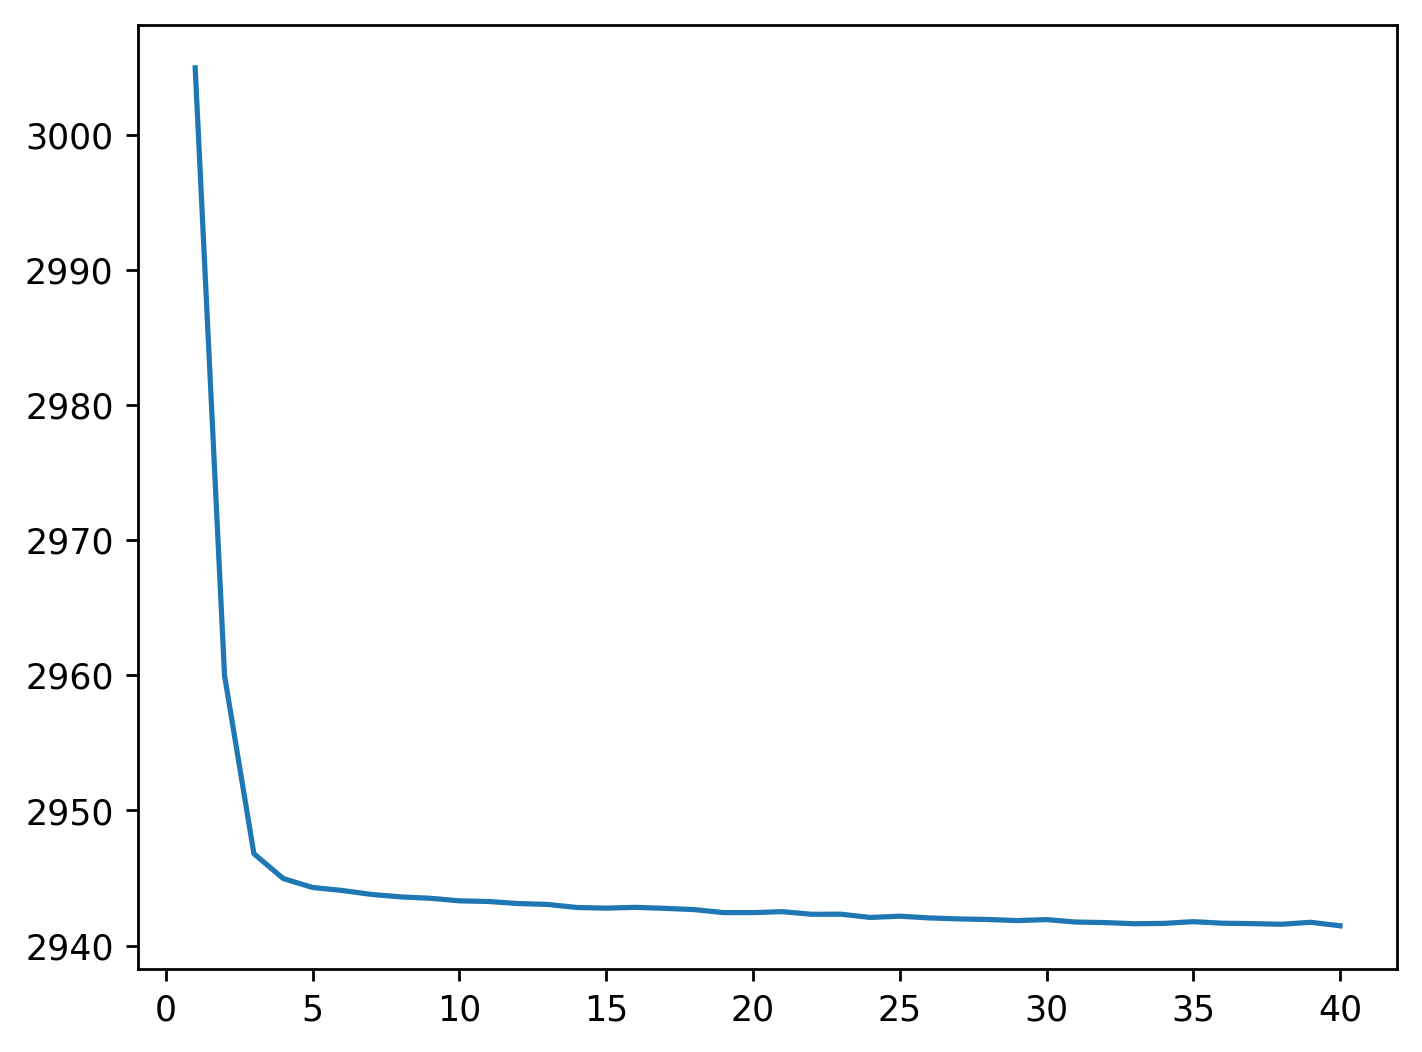

In [10]:
plt.figure(figsize=(6.5,5), dpi=250)

plt.plot(range(1,41), hist.history['mse'])

plt.show()

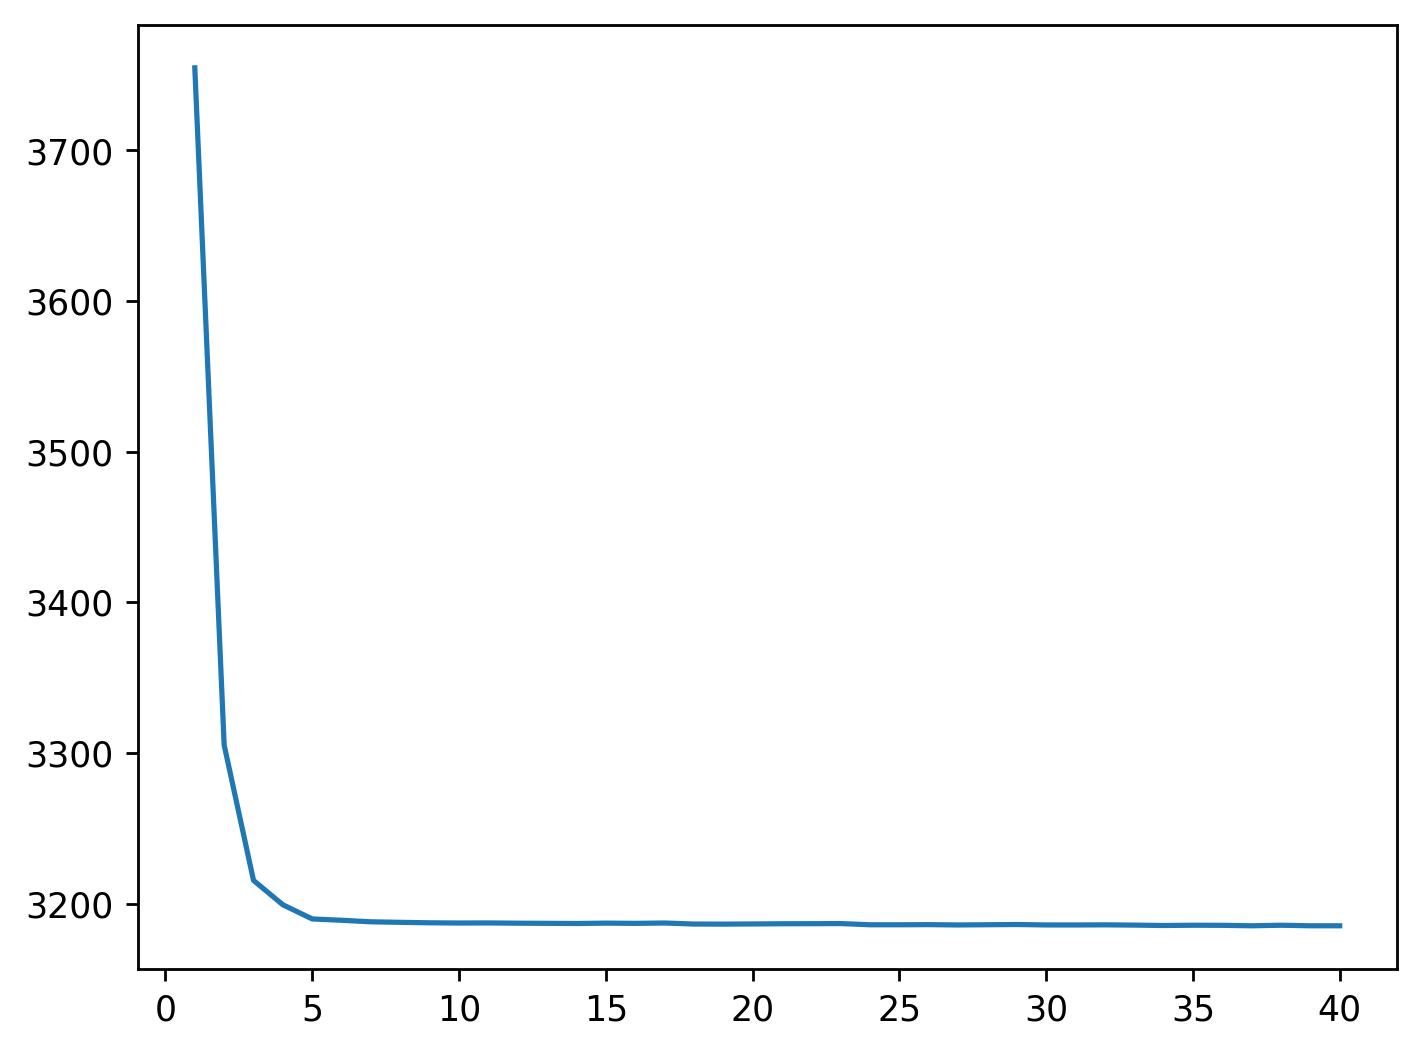

In [11]:
plt.figure(figsize=(6.5,5), dpi=250)

plt.plot(range(1,41), hist.history['val_mse'])

plt.show()

In [12]:
#perform a grid search in order to find the (approximately) best hyperparameter min_samples_leaf and max_features
#values that will be checked
max_features_list = [1,2]
min_samples_leaf_list = [50,100,250,500,750,1000,1250,1500,1750,2000]
opt_param = np.full(2,0)
opt_score = np.inf

for max_features in max_features_list:
    for min_samples_leaf in min_samples_leaf_list:
        rfr_tuning = RandomForestRegressor(n_estimators=160, max_features=max_features, min_samples_leaf=min_samples_leaf, bootstrap=True, criterion='squared_error', verbose=0, n_jobs=-1)
        rfr_tuning.fit(X=X_tau_train, y=Y_train)
        score = mean_squared_error(y_true=Y_val, y_pred=rfr_tuning.predict(X_tau_val))
        print('min_samples_leaf: ', min_samples_leaf, ', max_features:',max_features, ', MSE: ', score)
        if score < opt_score:
            opt_param_RF = np.array([max_features,min_samples_leaf])
            opt_score = score
            print('New best!')

print('Best parameters found in grid search: ', opt_param_RF, ' with MSE ', opt_score)

min_samples_leaf:  50 , max_features: 1 , MSE:  3195.0061218965366
New best!
min_samples_leaf:  100 , max_features: 1 , MSE:  3191.104346023506
New best!
min_samples_leaf:  250 , max_features: 1 , MSE:  3188.887215407729
New best!
min_samples_leaf:  500 , max_features: 1 , MSE:  3188.495845819278
New best!
min_samples_leaf:  750 , max_features: 1 , MSE:  3188.437932295749
New best!
min_samples_leaf:  1000 , max_features: 1 , MSE:  3189.1677996638527
min_samples_leaf:  1250 , max_features: 1 , MSE:  3188.896811046465
min_samples_leaf:  1500 , max_features: 1 , MSE:  3189.030621779755
min_samples_leaf:  1750 , max_features: 1 , MSE:  3189.8127739383826
min_samples_leaf:  2000 , max_features: 1 , MSE:  3190.559391678674
min_samples_leaf:  50 , max_features: 2 , MSE:  3200.492683430762
min_samples_leaf:  100 , max_features: 2 , MSE:  3194.0301110618566
min_samples_leaf:  250 , max_features: 2 , MSE:  3189.858252138194
min_samples_leaf:  500 , max_features: 2 , MSE:  3187.8514892177113
New 

In [28]:
#trees will be added to the random forest consecutively in these steps, i.e. steps of 40
n_tree_steps = []
for i in range(40,1001,40):
    n_tree_steps.append(int(i))

mse_train_RF = []
mse_val_RF = []

#definition of the random forest with optimal parameters from the tuning procedure
rfr = RandomForestRegressor(n_estimators=0, criterion='squared_error', max_features=int(opt_param_RF[0]), min_samples_leaf=int(opt_param_RF[1]), bootstrap=True, verbose=0, warm_start=True, n_jobs=-1)

#training of the random forest by consecutively adding trees according to n_tree_steps and computation of training and validation MSE after each such step
for n in n_tree_steps:
    rfr.n_estimators = n
    rfr.fit(X=X_tau_train, y=Y_train)
    joblib.dump(rfr, filepath_wd + 'VarAnn_'+str(n)+'.joblib')
    mse_train_RF.append(((rfr.predict(X_tau_train)-Y_train)**2).mean())
    mse_val_RF.append(((rfr.predict(X_tau_val)-Y_val)**2).mean())
    print(n,'of',n_tree_steps[-1],'trees built')

40 of 1000 trees built
80 of 1000 trees built
120 of 1000 trees built
160 of 1000 trees built
200 of 1000 trees built
240 of 1000 trees built
280 of 1000 trees built
320 of 1000 trees built
360 of 1000 trees built
400 of 1000 trees built
440 of 1000 trees built
480 of 1000 trees built
520 of 1000 trees built
560 of 1000 trees built
600 of 1000 trees built
640 of 1000 trees built
680 of 1000 trees built
720 of 1000 trees built
760 of 1000 trees built
800 of 1000 trees built
840 of 1000 trees built
880 of 1000 trees built
920 of 1000 trees built
960 of 1000 trees built
1000 of 1000 trees built


Plots of training and validation MSE of the random forest.

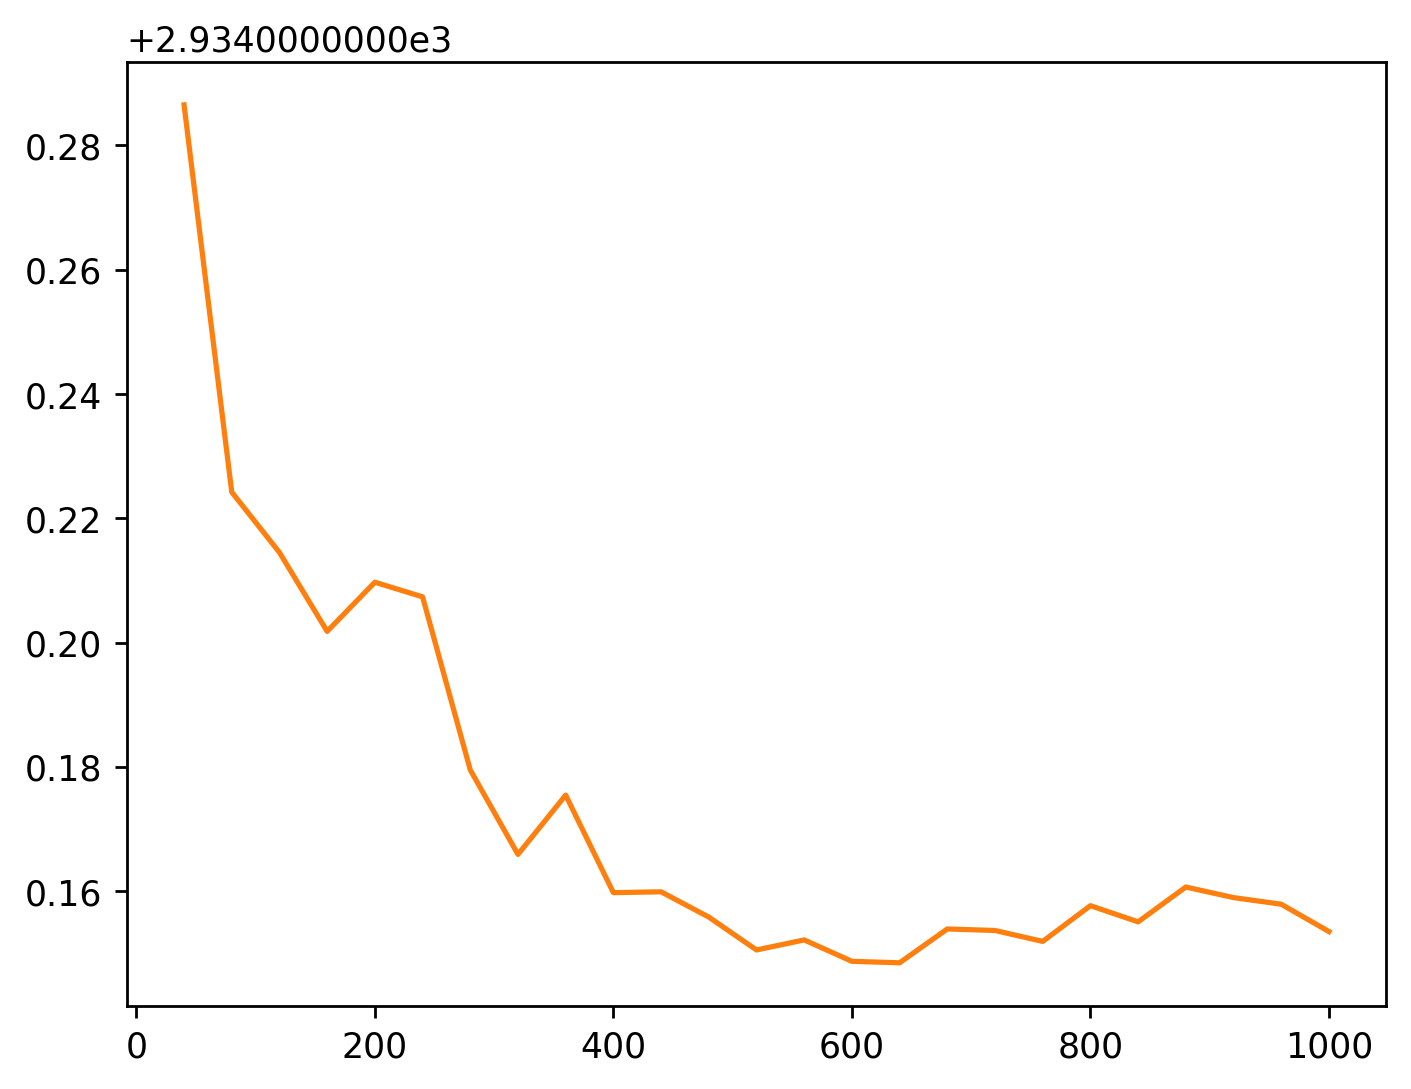

In [29]:
plt.figure(figsize=(6.5,5), dpi=250)

plt.plot(n_tree_steps, mse_train_RF, color='tab:orange')

plt.show()

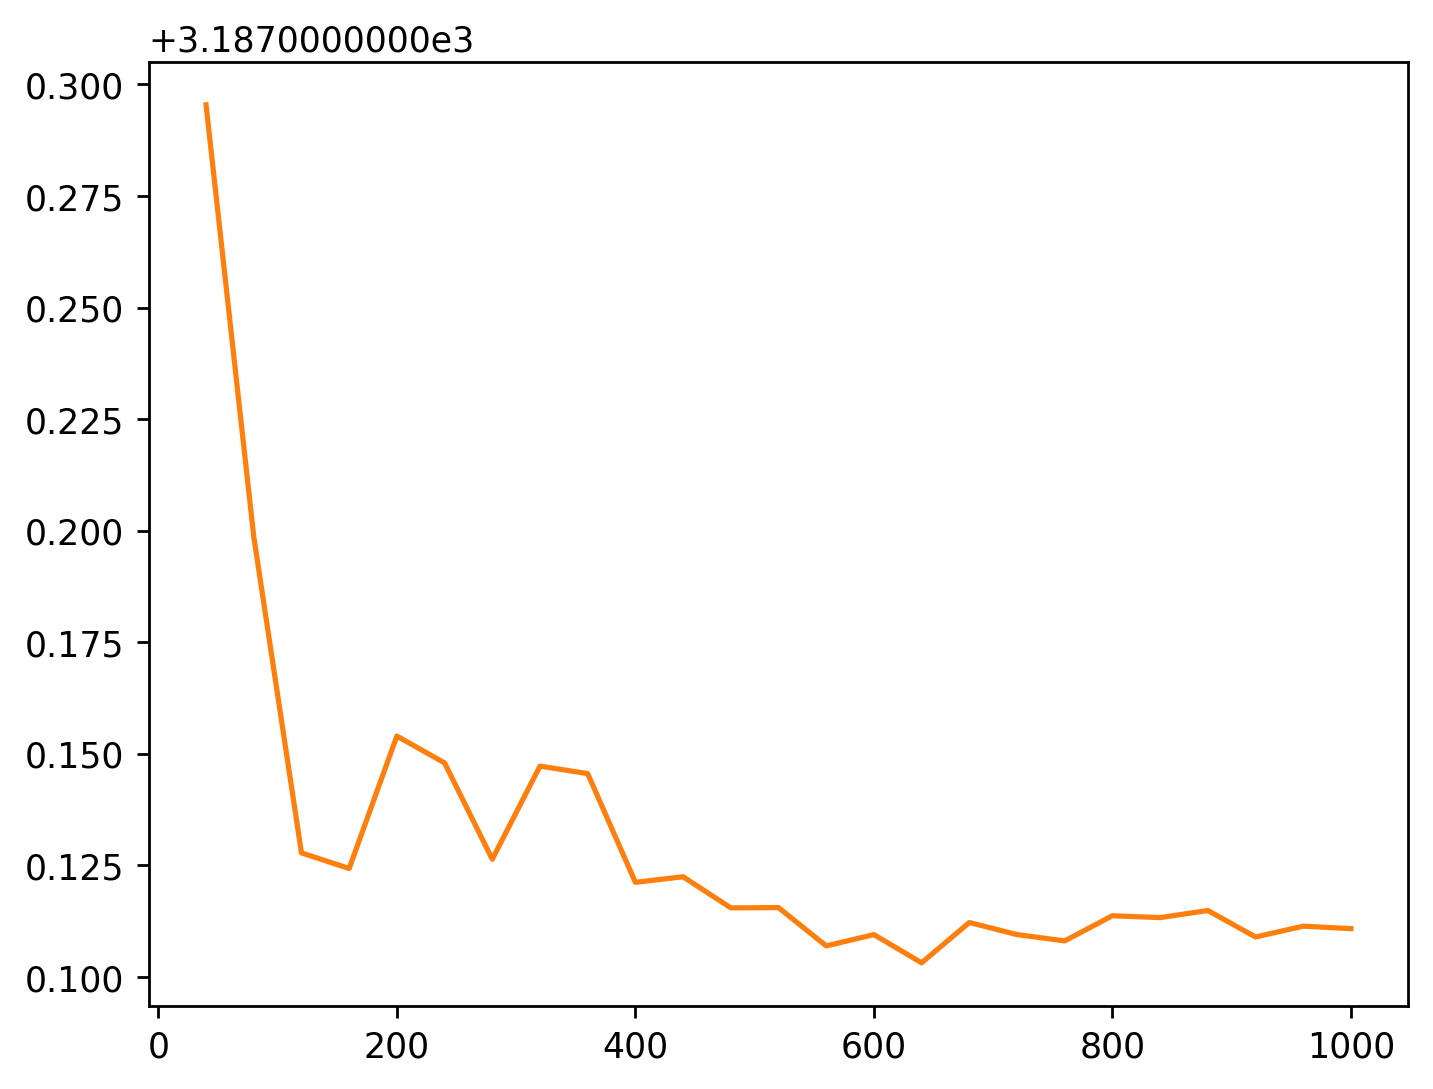

In [30]:
plt.figure(figsize=(6.5,5), dpi=250)

plt.plot(n_tree_steps, mse_val_RF, color='tab:orange')

plt.show()

In [31]:
#Calculating the parts of the test set that fall into B_1 and B_2
q_70 = stats.norm.ppf(0.7, loc=mu_q_tau, scale=var_q_tau)
q_30 = stats.norm.ppf(0.3, loc=mu_q_tau, scale=var_q_tau)
r_70 = stats.norm.ppf(0.7, loc=mu_r_tau, scale=var_r_tau)
r_30 = stats.norm.ppf(0.3, loc=mu_r_tau, scale=var_r_tau)

B_1 = np.apply_along_axis(np.all, axis=1, arr=np.column_stack( (X_tau_test[:,0] > q_70, X_tau_test[:,1] < r_30)) )
B_2 = np.apply_along_axis(np.all, axis=1, arr=np.column_stack( (X_tau_test[:,0] < q_30, X_tau_test[:,1] > r_70)) )

In [32]:
#loading the saved neural network models after every epoch
models_eval = []
for i in range(1,41):
    models_eval.append(tf.keras.models.load_model(filepath_wd + "VarAnn_saved_epoch_" + str(i) + ".hdf5"))

In [33]:
#computation of the metrics (a), (b), (c) with B_1 and (c) with B_2 for the neural network
metric_a_NN = []
metric_b_NN = []
metric_c_B_1_NN = []
metric_c_B_2_NN = []

for i in range(0,40):
    Y_pred_tmp = models_eval[i].predict(X_tau_test)[:,0]

    ma_tmp = np.sum(Y_pred_tmp - Y_test)/len(Y_test)
    metric_a_NN.append(ma_tmp)

    mb_tmp = np.sum((Y_pred_tmp - Y_test) * Y_pred_tmp)/len(Y_test)
    metric_b_NN.append(mb_tmp)

    mc_tmp = Y_pred_tmp - Y_test
    mc_1_tmp = np.sum(mc_tmp[B_1])/len(Y_test)
    mc_2_tmp = np.sum(mc_tmp[B_2])/len(Y_test)
    metric_c_B_1_NN.append(mc_1_tmp)
    metric_c_B_2_NN.append(mc_2_tmp)

Plots of metrics a, b, c with B_1 and B_2 with the evolving training process, i.e. on the $x$-axes of the following plots is the number of epochs.

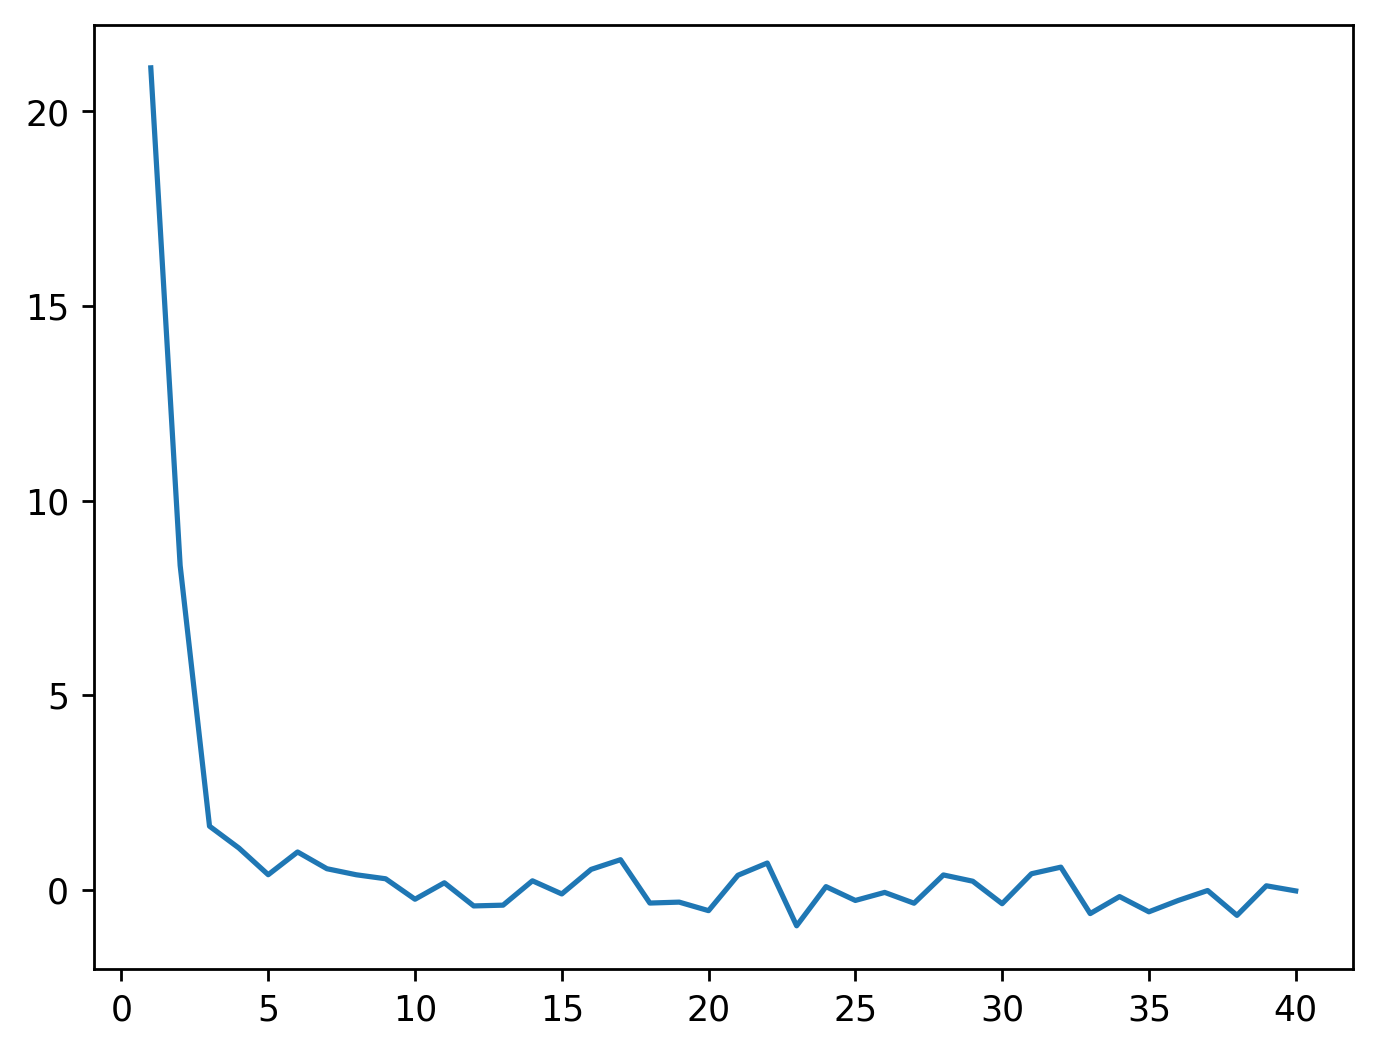

In [34]:
plt.figure(figsize=(6.5,5), dpi=250)

plt.plot(range(1,41), metric_a_NN)

plt.show()

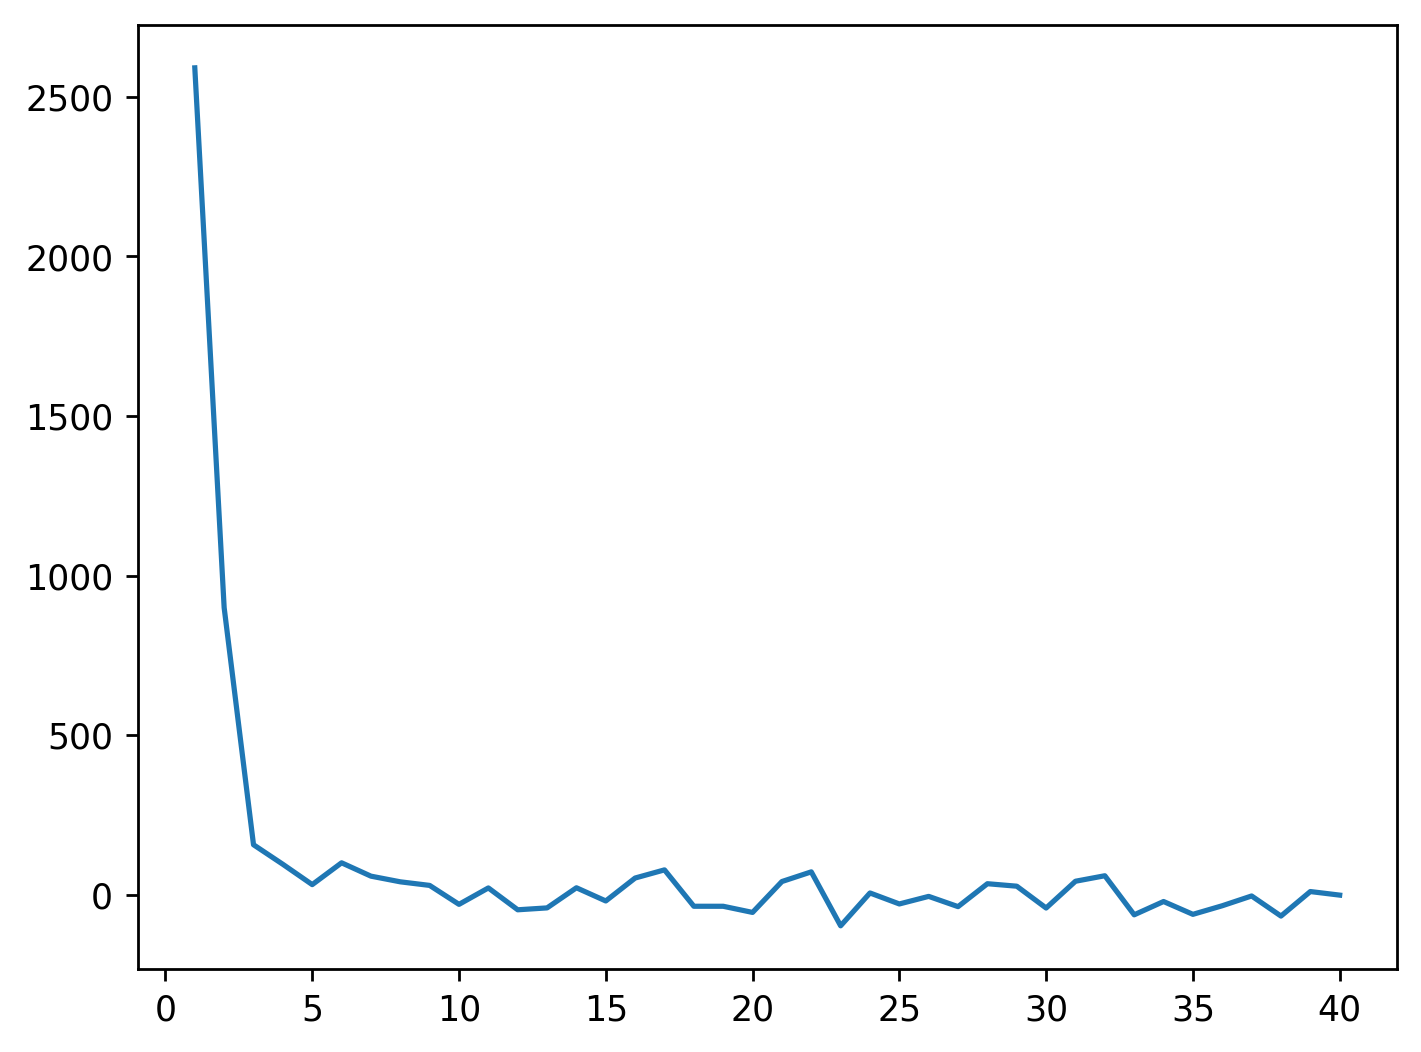

In [35]:
plt.figure(figsize=(6.5,5), dpi=250)

plt.plot(range(1,41), metric_b_NN)

plt.show()

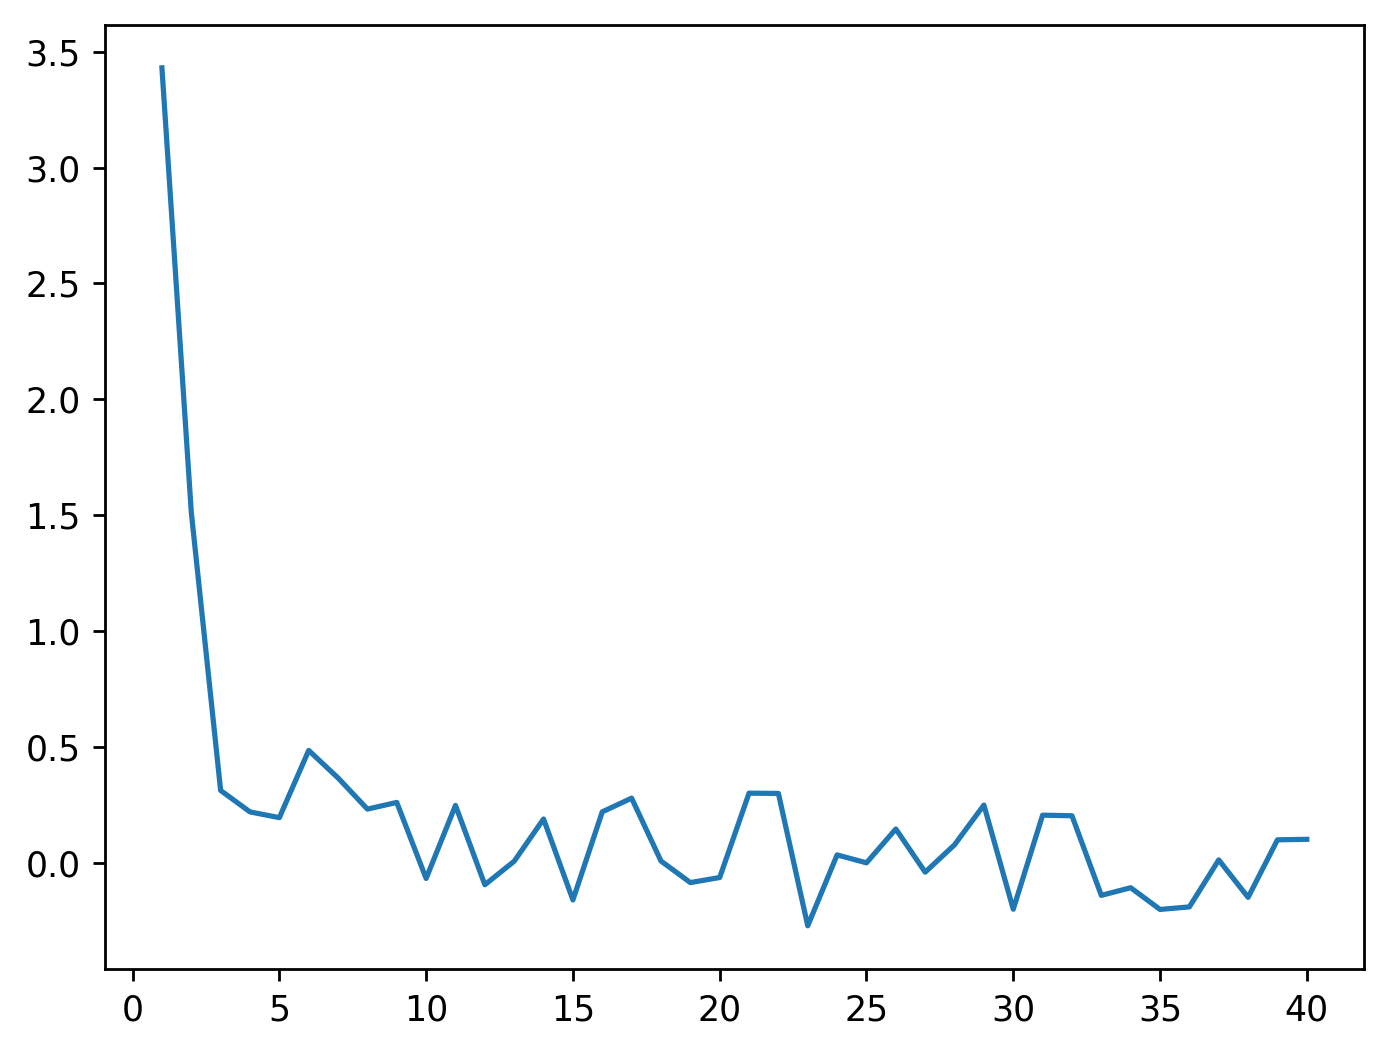

In [36]:
plt.figure(figsize=(6.5,5), dpi=250)

plt.plot(range(1,41), metric_c_B_1_NN)

plt.show()

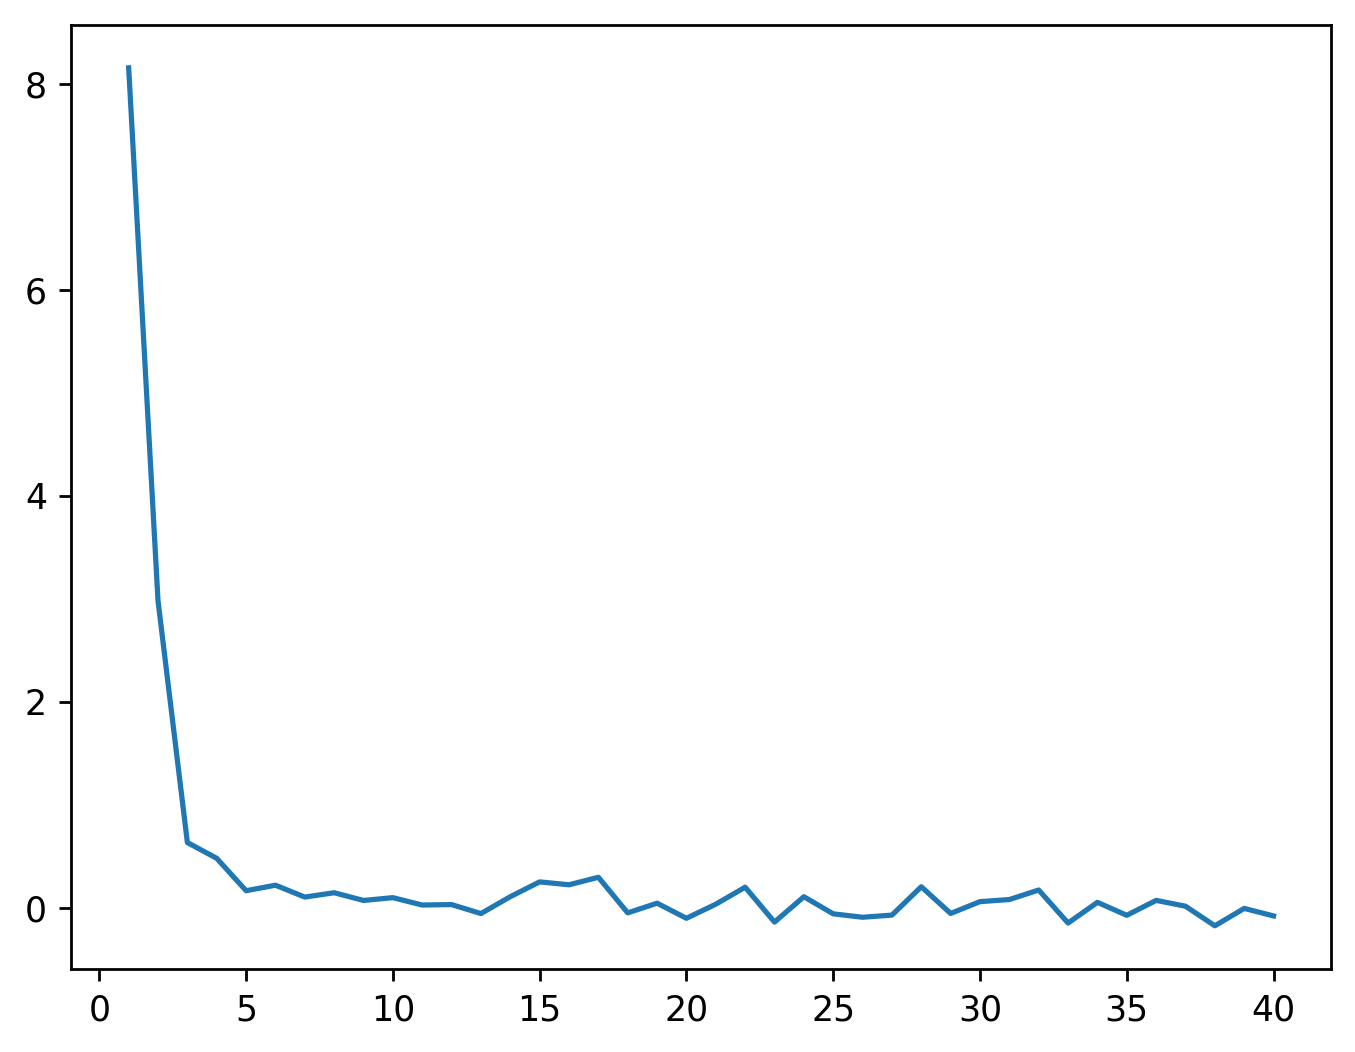

In [37]:
plt.figure(figsize=(6.5,5), dpi=250)

plt.plot(range(1,41), metric_c_B_2_NN)

plt.show()

In [38]:
#computation of the metrics (a), (b), (c) with B_1 and (c) with B_2 for the random forest
metric_a_RF = []
metric_b_RF = []
metric_c_B_1_RF = []
metric_c_B_2_RF = []

for n in n_tree_steps:
    Y_pred_tmp = joblib.load(filepath_wd + 'VarAnn_'+str(n)+'.joblib').predict(X_tau_test)

    ma_tmp = np.sum(Y_pred_tmp - Y_test)/len(Y_test)
    metric_a_RF.append(ma_tmp)

    mb_tmp = np.sum((Y_pred_tmp - Y_test) * Y_pred_tmp)/len(Y_test)
    metric_b_RF.append(mb_tmp)

    mc_tmp = Y_pred_tmp - Y_test
    mc_1_tmp = np.sum(mc_tmp[B_1])/len(Y_test)
    mc_2_tmp = np.sum(mc_tmp[B_2])/len(Y_test)
    metric_c_B_1_RF.append(mc_1_tmp)
    metric_c_B_2_RF.append(mc_2_tmp)

Plots of metrics a, b, c with B_1 and B_2 with the evolving training process, i.e. on the $x$-axes of the following plots is the number of added trees in steps of 40.

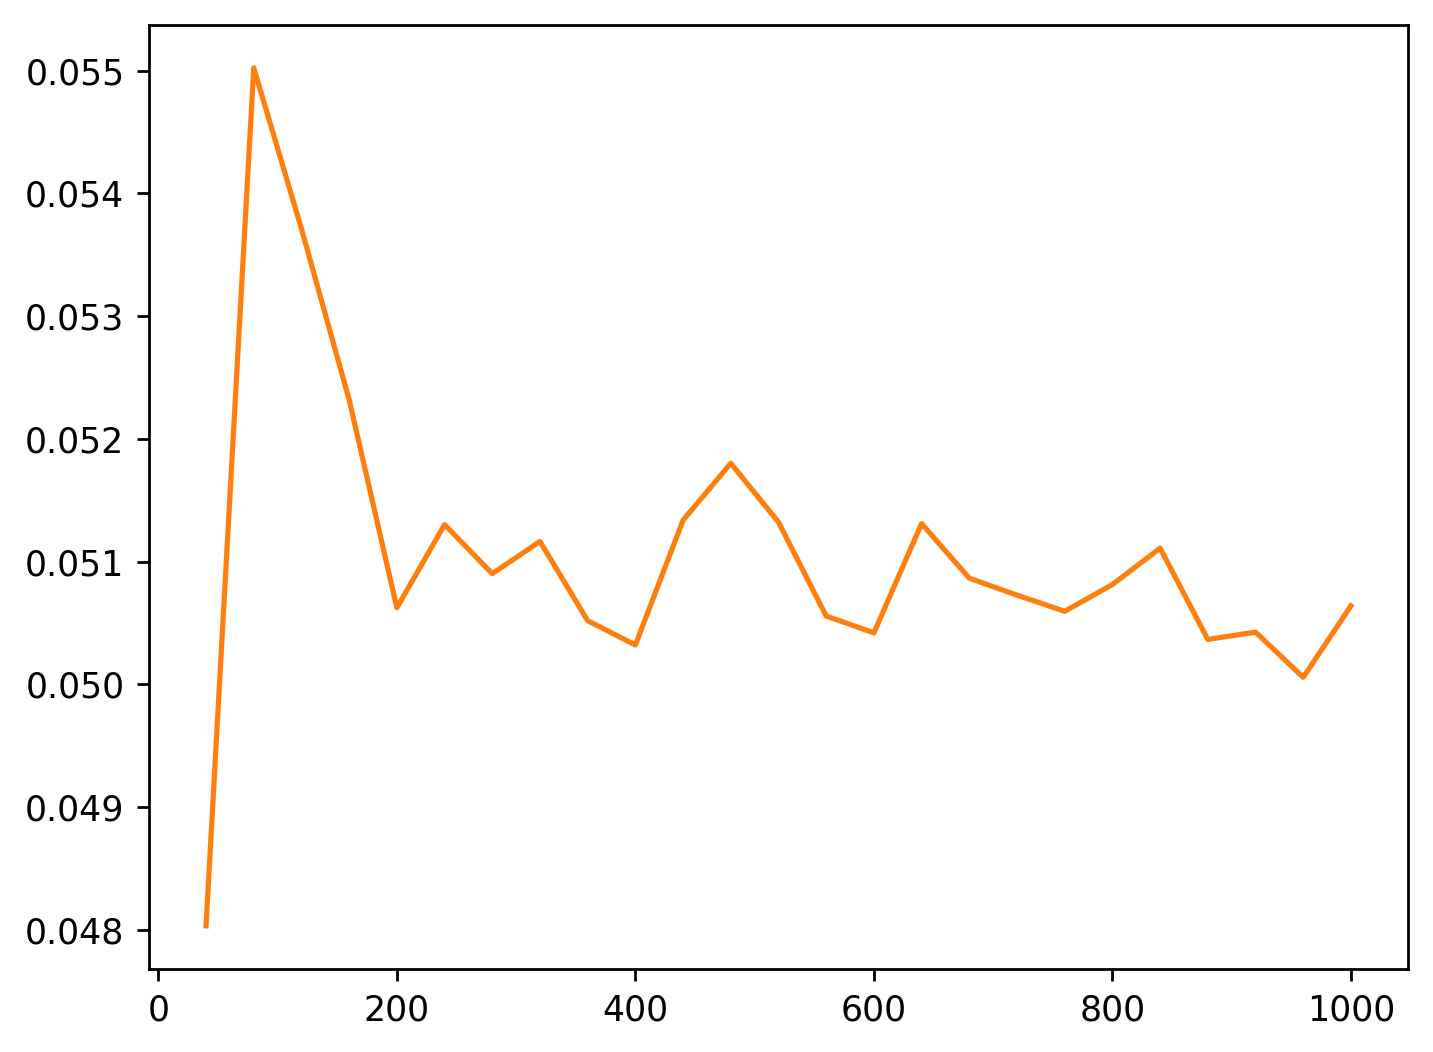

In [39]:
plt.figure(figsize=(6.5,5), dpi=250)

plt.plot(n_tree_steps, metric_a_RF, color='tab:orange')

plt.show()

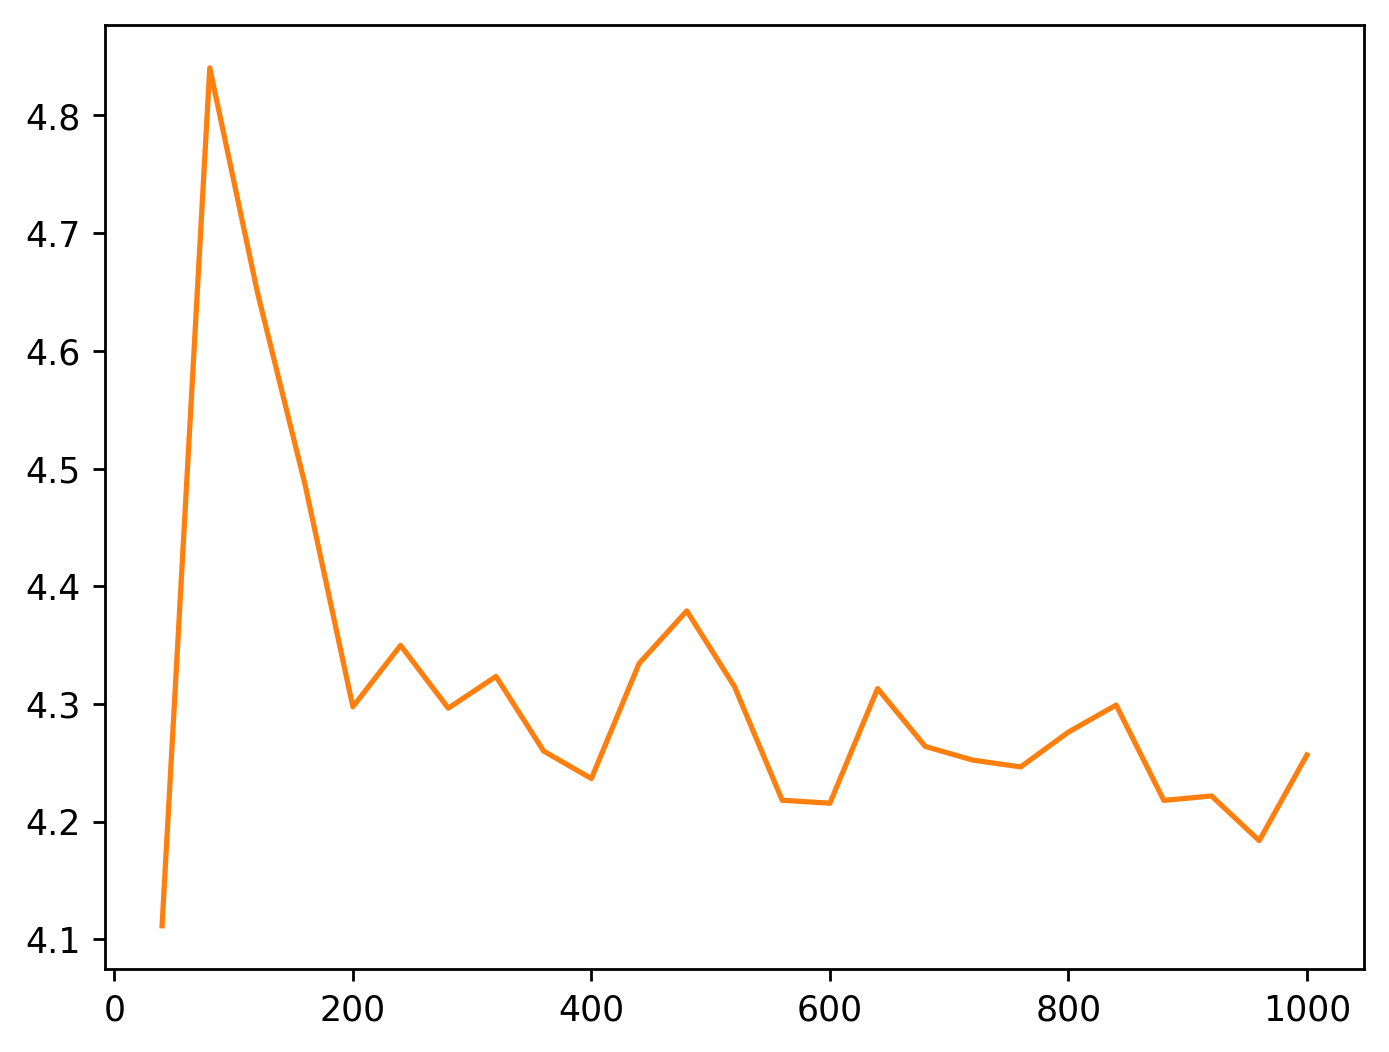

In [40]:
plt.figure(figsize=(6.5,5), dpi=250)

plt.plot(n_tree_steps, metric_b_RF, color='tab:orange')

plt.show()

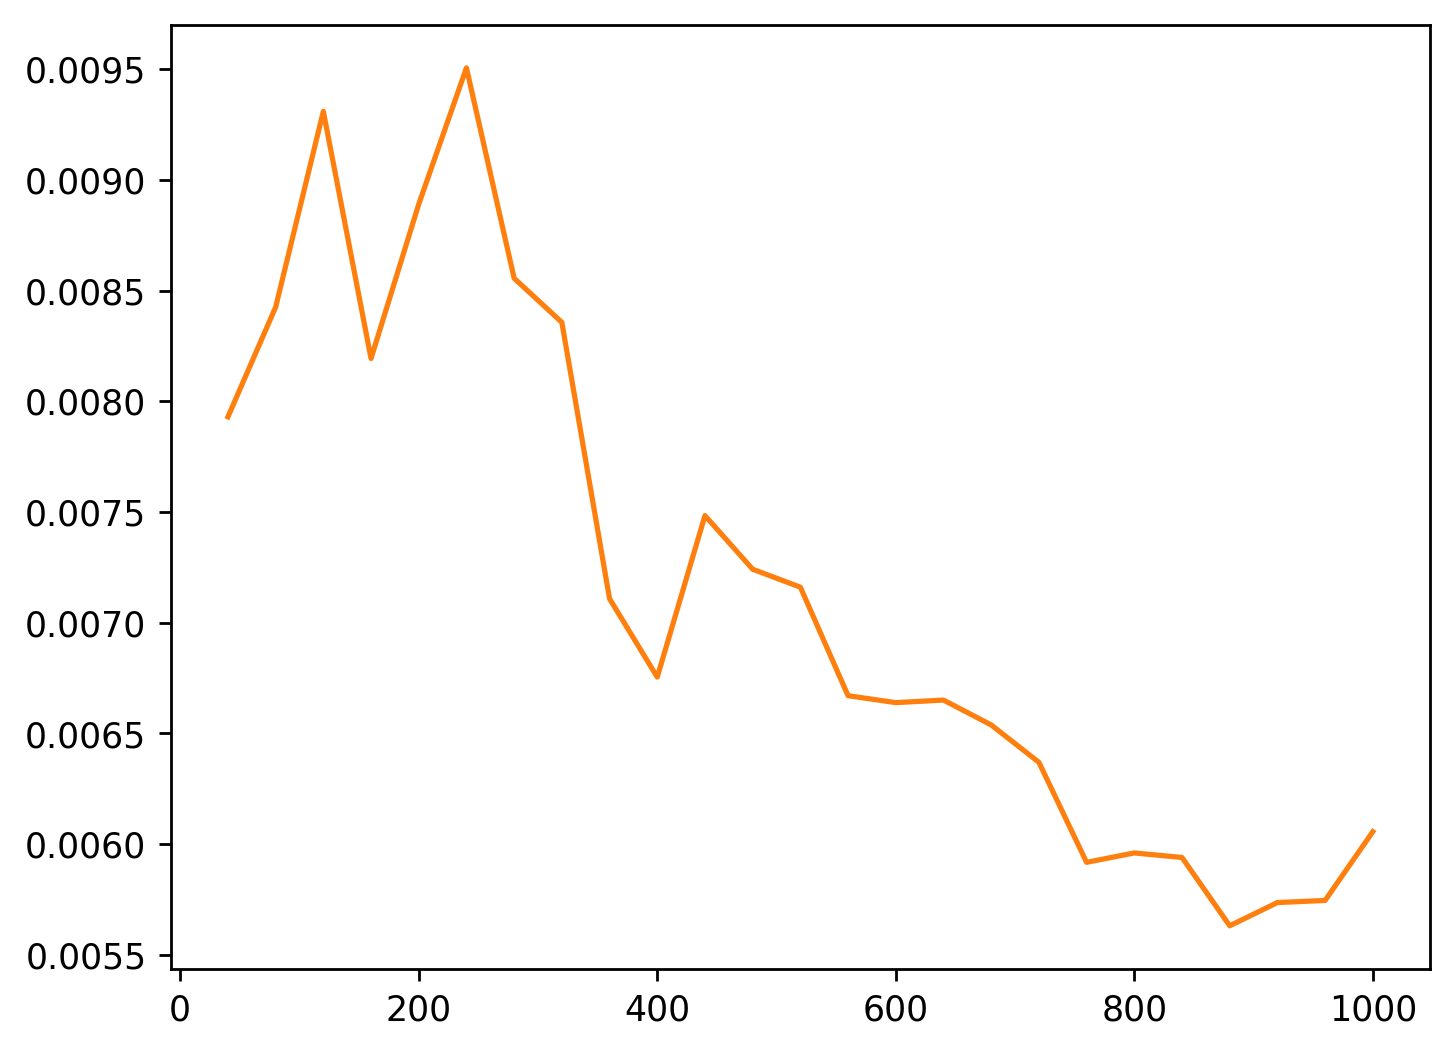

In [41]:
plt.figure(figsize=(6.5,5), dpi=250)

plt.plot(n_tree_steps, metric_c_B_1_RF, color='tab:orange')

plt.show()

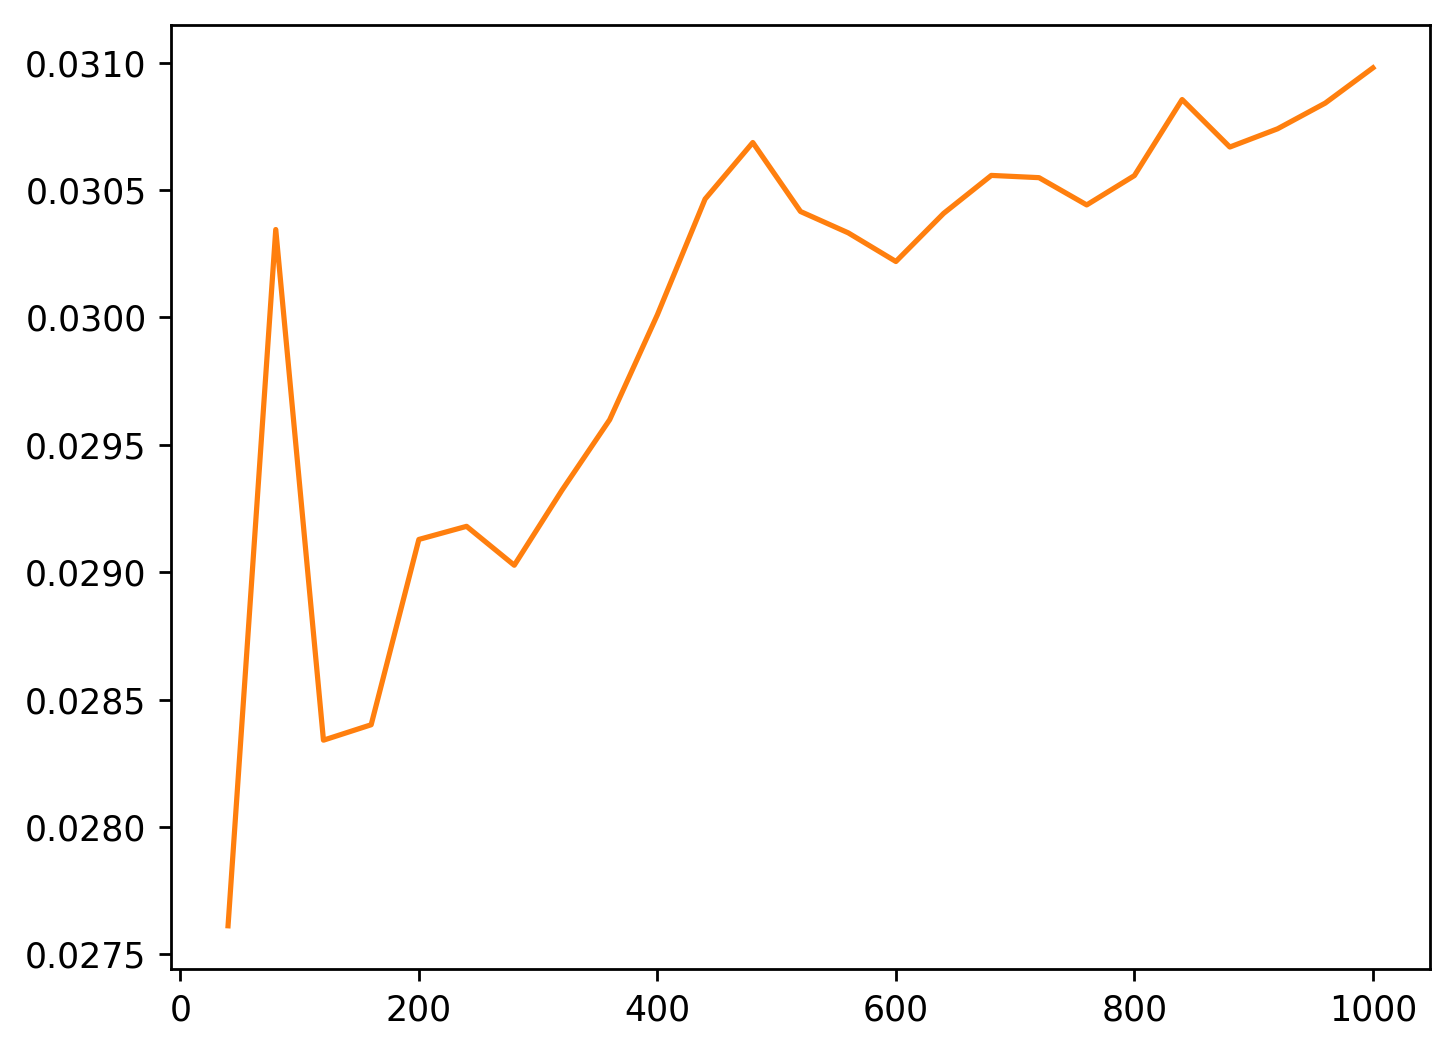

In [42]:
plt.figure(figsize=(6.5,5), dpi=250)

plt.plot(n_tree_steps, metric_c_B_2_RF, color='tab:orange')

plt.show()

In [43]:
#Simulation of X_tau
X_tau_MC,Y_MC = data_gen(M=500000,N=1)

#calculation of risk measures in a stepwise procedure
#number of steps
step_number = 200
i = 500000/step_number

In [44]:
#initialisation of risk measure estimators
VaR_hat_NN = []
ES_hat_NN = []
GlueVaR_hat_NN = []
VaR_hat_RF = []
ES_hat_RF = []
GlueVaR_hat_RF = []

#Prediction of payoff Y
Y_pred_NN = model.predict(X_tau_MC)[:,0]
Y_pred_RF = np.ndarray.tolist(rfr.predict(X_tau_MC))

for n in range(1,step_number+1):
    #computation of risk measure estimators
    #sort observations
    L_NN = np.sort(Y_pred_NN[0:int(n*i)])[::-1]
    L_RF = np.sort(Y_pred_RF[0:int(n*i)])[::-1]

    #Value-at-Risk
    j_VaR = int(n*i*(1-alpha_VaR))-1
    VaR_hat_NN.append(L_NN[j_VaR])
    VaR_hat_RF.append(L_RF[j_VaR])

    #Expected Shortfall
    j_ES = int(n*i*(1-alpha_ES))-1
    ES_hat_NN.append( 1/(1-alpha_ES) * np.sum(L_NN[0:j_ES-1])/(n*i) + ( 1 - (j_ES-1)/((1-alpha_ES)*n*i) )*L_NN[j_ES])
    ES_hat_RF.append( 1/(1-alpha_ES) * np.sum(L_RF[0:j_ES-1])/(n*i) + ( 1 - (j_ES-1)/((1-alpha_ES)*n*i) )*L_RF[j_ES])
    
    #GlueVaR
    GlueVaR_hat_NN.append(GlueVaR(omega=omega_Glue, L=L_NN, alpha=alpha_Glue, beta=beta_Glue))
    GlueVaR_hat_RF.append(GlueVaR(omega=omega_Glue, L=L_RF, alpha=alpha_Glue, beta=beta_Glue))

Plots of the risk measure estimators calculated in the stepwise procedure.

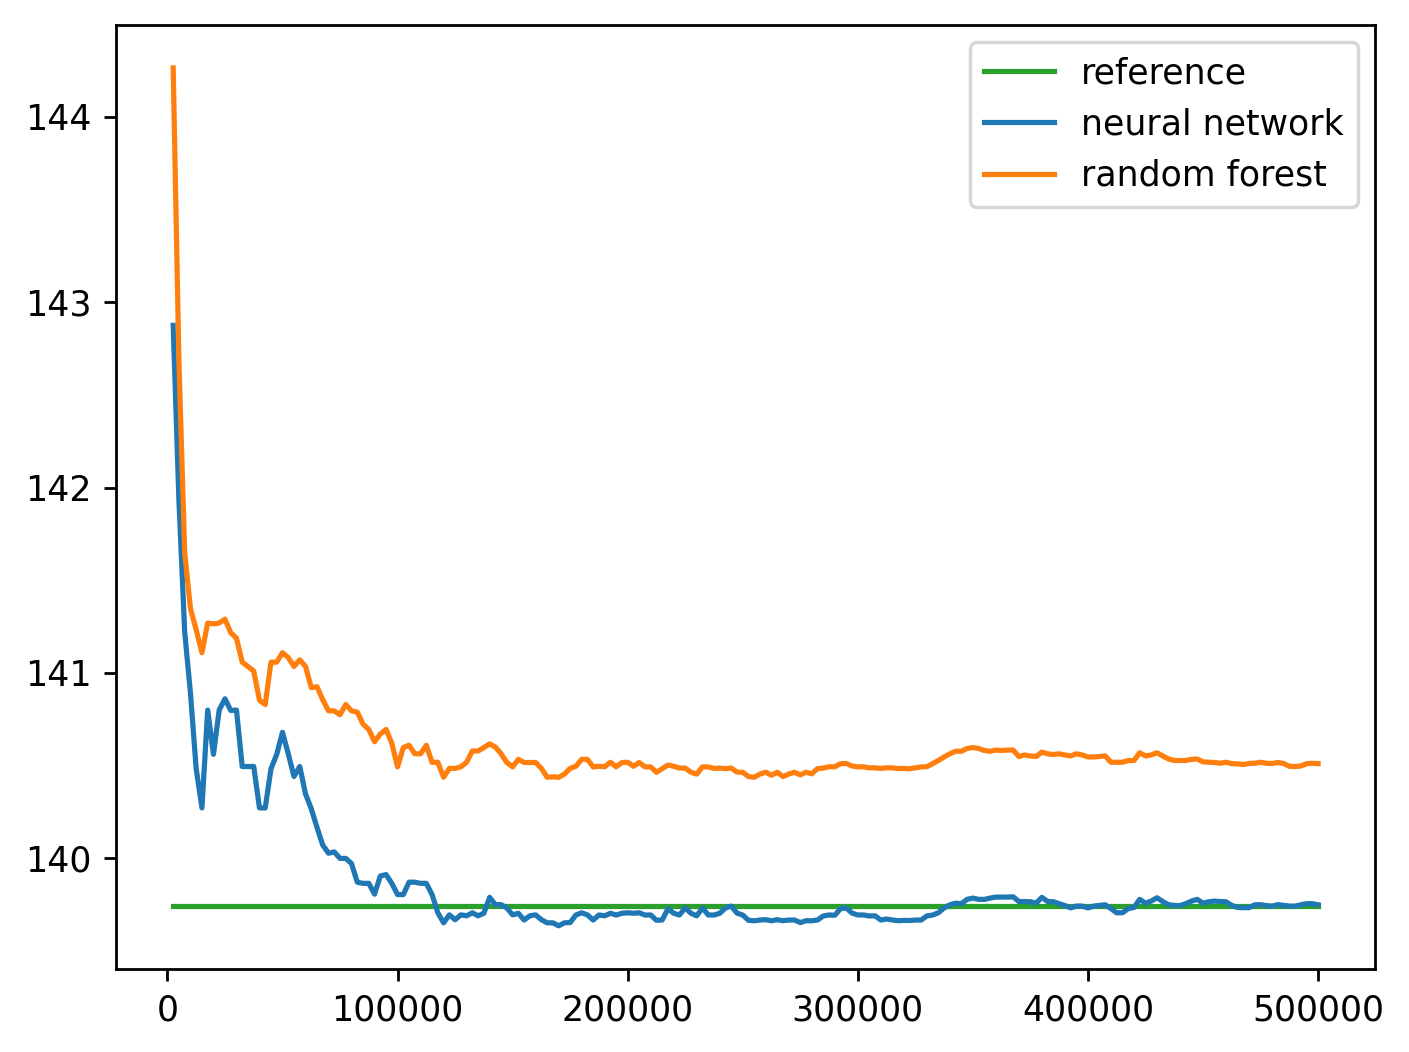

In [45]:
steps = np.linspace(i, 500000, step_number)

plt.figure(figsize=(6.5,5), dpi=250)

plt.plot(steps, np.full(step_number, 139.74), color='tab:green')
plt.plot(steps, VaR_hat_NN, color='tab:blue')
plt.plot(steps, VaR_hat_RF, color='tab:orange')
plt.legend(['reference', 'neural network', 'random forest'])

plt.show()

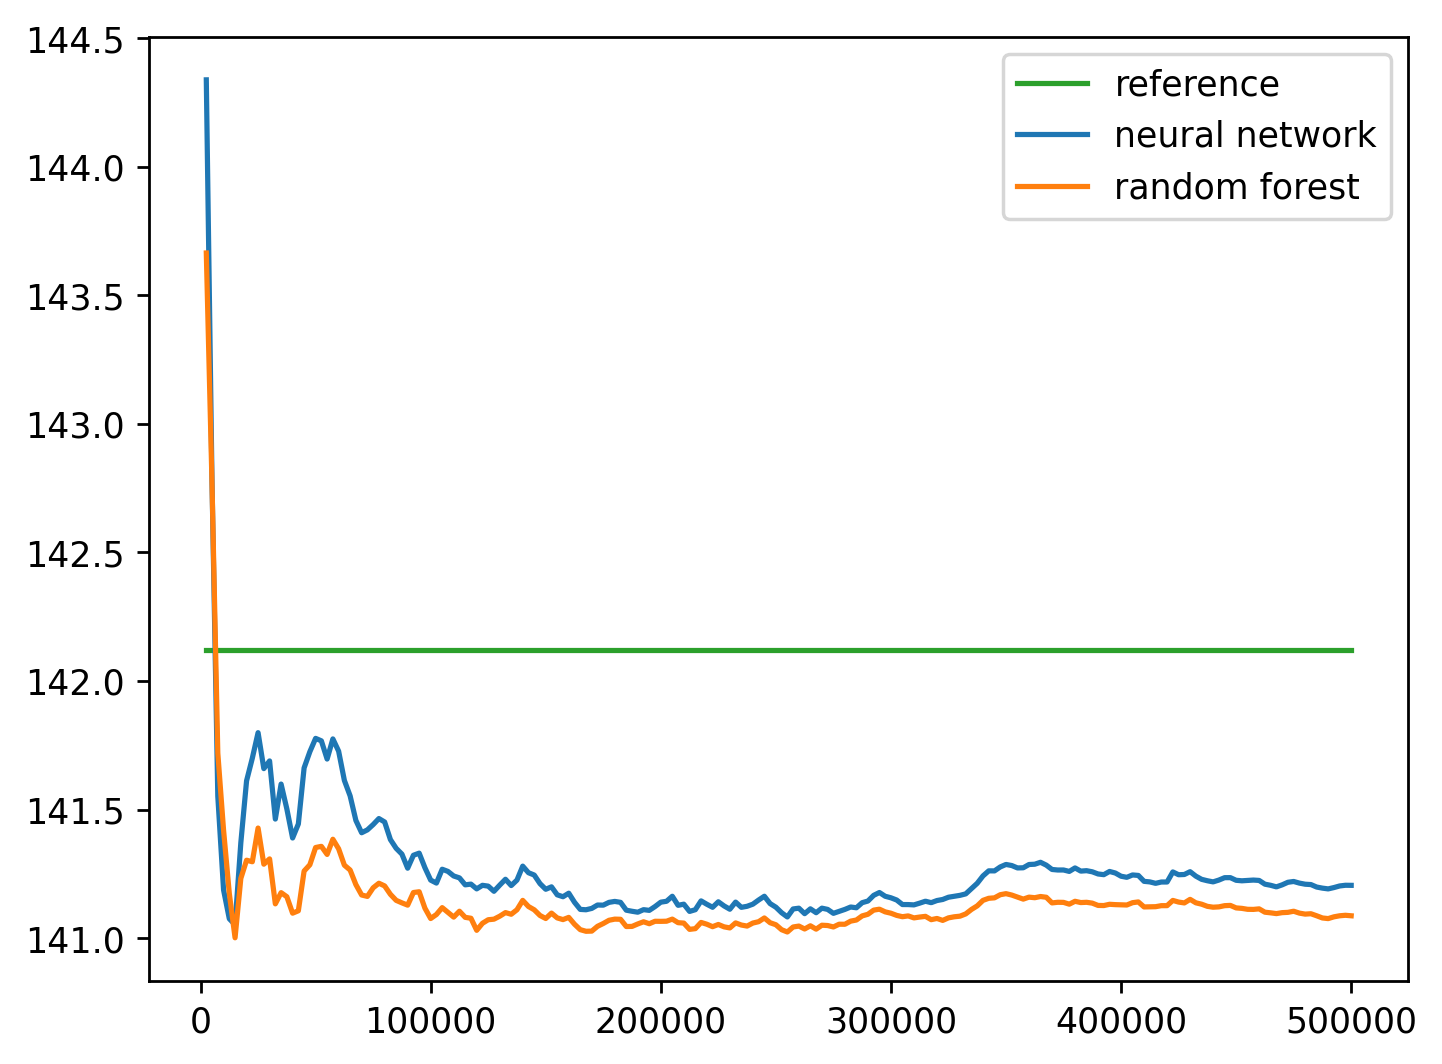

In [46]:
steps = np.linspace(i, 500000, step_number)

plt.figure(figsize=(6.5,5), dpi=250)

plt.plot(steps, np.full(step_number, 142.12), color='tab:green')
plt.plot(steps, ES_hat_NN, color='tab:blue')
plt.plot(steps, ES_hat_RF, color='tab:orange')

plt.legend(['reference','neural network','random forest'])

plt.show()

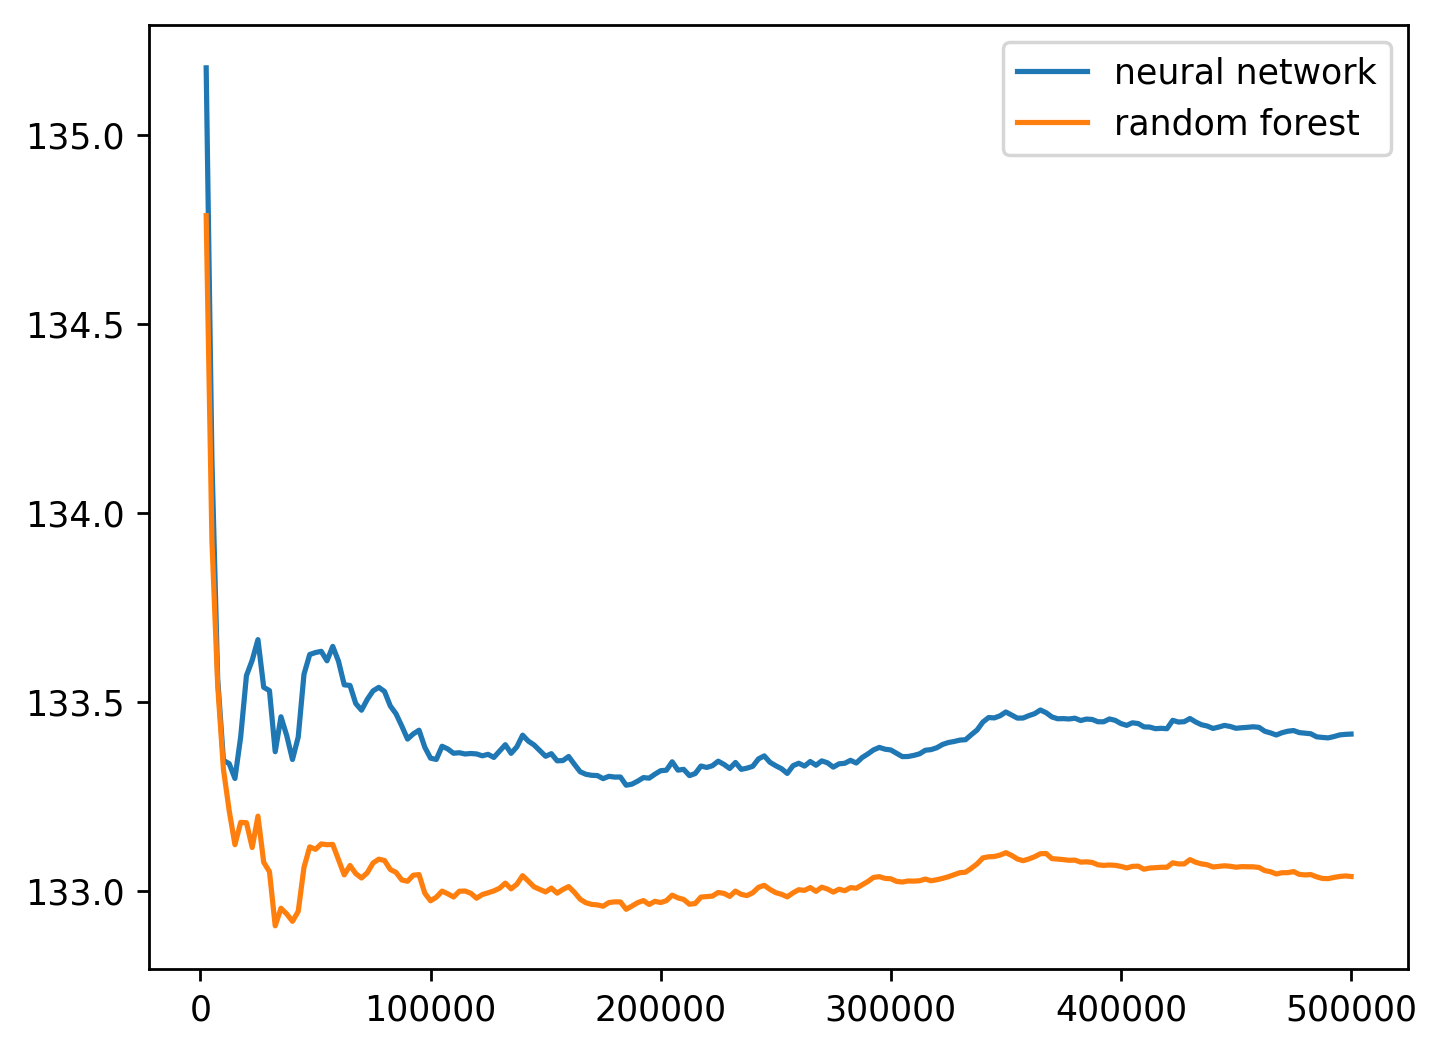

In [47]:
plt.figure(figsize=(6.5,5), dpi=250)

plt.plot(steps, GlueVaR_hat_NN, color='tab:blue')
plt.plot(steps, GlueVaR_hat_RF, color='tab:orange')
plt.legend(['neural network', 'random forest'])

plt.show()

In [48]:
#Saving the computed risk measure estimators such that they can be compared to estimators produced with usage of the importance sampling procedure in another notebook (single_run_eval.ipynb)
joblib.dump(VaR_hat_NN, filepath+'VaR_hat_NN.joblib')
joblib.dump(ES_hat_NN, filepath+'ES_hat_NN.joblib')
joblib.dump(GlueVaR_hat_NN, filepath+'GlueVaR_hat_NN.joblib')
joblib.dump(VaR_hat_RF, filepath+'VaR_hat_RF.joblib')
joblib.dump(ES_hat_RF, filepath+'ES_hat_RF.joblib')
joblib.dump(GlueVaR_hat_RF, filepath+'GlueVaR_hat_RF.joblib')

['/pfs/data5/home/ul/ul_student/ul_ynv73/VarAnn/saved_mix/GlueVaR_hat_RF.joblib']